## Numpy 를 이용한 Linear Regression 구현 

지난번 수업에서 Data, Model, Loss(Objective Function) 을 정의하고 '학습(Train)' 이라는 과정이 어떻게 이루어지는지에 대해서 간략하게 개념을 알아보고, 수식도 그려보고 했었지요. 여기까지만 해도 다들 잘 따라오신 것 같았는데, Logistic Regression 으로 가면서 약간 힘들어지셨었죠. 

Model 은 간단히 y = wx + b 의 수식을 만들고 loss 는 MSE(Mean Squared Error)를 이용해서 매우매우 간단한 Linear Regression 을 구성해봤었는데요. 오늘은 그 내용을 numpy 를 이용해서 간단히 한번 구현해보도록 하겠습니다. 

(본 수업은 Andrew Ng 교수님의 deeplearning.ai 의 Deep Learning specialization course 1 에 최대한 맞추어서 만들어졌으니, 강연을 최대한 참고해주시기 바랍니다. 거듭 말씀드리지만 Course-1 만 잘 이해해도 기본개념탑재는 이루어진거나 마찬가지입니다. 저도 뭐 깊게깊게 들어갈 생각 없습니다.)

https://www.kaggle.com/mohansacharya/graduate-admissions 

데이터는 Kaggle 에서 가져왔구요. Data 의 각각의 컬럼은 아래처럼 이루어져 있네요.

GRE Scores ( out of 340 )
TOEFL Scores ( out of 120 )
University Rating ( out of 5 )
Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
Undergraduate GPA ( out of 10 )
Research Experience ( either 0 or 1 )
Chance of Admit ( ranging from 0 to 1 )

GRE 이외에 다른 score 들도 다 집어넣은 모델을 만들 수 있겠으나 우리가 모델을 매우 간단한 1 차식 형태인 y = wx + b 의 형태로 구성했기에 GRE score 에 따른 합격확률(chance of admit)을 예측하는 모델을 만들고 학습해 보도록 하겠습니다.

학습을 끝내고 나면 우리가 설정한 Model 은 어떠한 능력을 갖게 될까요? 
맞습니다. GRE score 를 입력하면 대학원에 합격할 확률을 알려주게 될겁니다. :)

__그럼 이제 다운로드 받은 'Admission_Predict.csv' 파일을 sample_data folder 에 넣어둔 다음에 데이터를 한번 읽어와 볼까요?__

(주의. google colab 에서 작업하시려면 위 데이터셋을 여러분의 sample_data folder 에 업로드해주셔야 합니다.)

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

csv = pd.read_csv("./sample_data/Admission_Predict.csv")

# 다 읽어온 다음에 data 가 어떤 모양을 하고 있는지 한번 살펴볼까요? 
csv.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


데이터가 어떠한 dimension 을 가지고 있는지 한번 살펴보고 pandas dataframe 으로 읽어온 데이터를 numpy data 로 변환합니다. 이때는 pandas 가 제공하는 to_numpy() 라는 method 를 사용하면 됩니다.  numpy 로 바꾼 이후에 dimension 을 한번 살펴볼까요?

In [117]:
print(csv.shape)
csv_np = csv.to_numpy()
print(csv_np.shape)

(400, 9)
(400, 9)


우리가 뽑아와야 하는 GRE Score 는 2번째 컬럼에 위치하고, 합격확률은 9번째 컬럼에 위치하니까 이 데이터를 뽑아와서 각각 x_train(입력데이터), y_train(레이블) 로 활용하도록 합시다. 

csv_np[:,1]  의 뜻은 1번째 컬럼만 뽑아오겠다는 이야기입니다. 

In [118]:
x_train = csv_np[:,1]
y_train = csv_np[:,8]

자 그럼 데이터가 어떠한 모양을 하고 있는지 한번 시각화를 해보도록 할까요? 

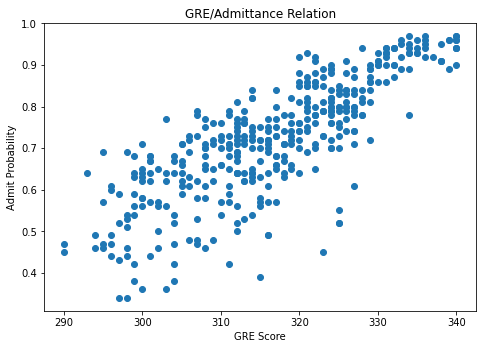

In [119]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter( x_train, y_train)
ax.set_xlabel('GRE Score')
ax.set_ylabel('Admit Probability')
ax.set_title('GRE/Admittance Relation')
plt.show()

#### 대충 어디에 선(line)을 쭈욱 그리면 얼추 모델이 완성되겠다라는 느낌이 오시죠?

인간의 뛰어난 지각력으로는 한번에 답을 낼 수 있습니다만, 컴터는 그러지 못하니 우리가 좀더 노가다를 해줘야겠습니다. 

pyplot 사용하는 문법은 저도 머리가 안좋아서 그렇지 외우고 있지 않습니다. 매일 코딩을 하는 것도 아니고 띄엄띄엄 코딩을 하다보니...  방금도 Google 에 'pyplot scatter point' 라고 검색하고 맨위에 나오는 샘플코드 그냥 베껴 쓴 겁니다... 언제는 왜 figure, axes 를 쓰고 어떤때는 안쓰냐.. 이런거 묻지 말아주세요 ㅠ.ㅠ 이런 것 정도는 그냥 알아서 하는 겁니다 :)

GRE score 를 그대로 사용하면 scale 이 맞지 않는 문제때문에 이를 0 에서 1 사이의 값을 갖도록 normalize 를 해줍니다. ( 주의할점은 model 을 학습할때 data 를 normalize 해서 썼으면 나중에 학습을 끝낸 모델을 이용해서 추론(inference)를 할때도 값들을 scale 해주어야 한다는 점을 잊으면 안됩니다. )



In [120]:
# numpy 의 broadcast 는 이런데서 위력을 발휘합니다. 
x_train = x_train / 340
print(x_train)

[0.99117647 0.95294118 0.92941176 0.94705882 0.92352941 0.97058824
 0.94411765 0.90588235 0.88823529 0.95       0.95588235 0.96176471
 0.96470588 0.90294118 0.91470588 0.92352941 0.93235294 0.93823529
 0.93529412 0.89117647 0.91764706 0.95588235 0.96470588 0.98235294
 0.98823529 1.         0.94705882 0.87647059 0.86764706 0.91176471
 0.88235294 0.96176471 0.99411765 1.         0.97352941 0.94117647
 0.87941176 0.88235294 0.89411765 0.90294118 0.90588235 0.92941176
 0.92058824 0.97647059 0.95882353 0.94705882 0.96764706 0.99705882
 0.94411765 0.96176471 0.92058824 0.91764706 0.98235294 0.95294118
 0.94705882 0.94117647 0.92941176 0.87647059 0.88235294 0.91470588
 0.90882353 0.90294118 0.89411765 0.92647059 0.95588235 0.95588235
 0.96176471 0.92941176 0.93529412 0.96470588 0.97647059 0.98823529
 0.94411765 0.92352941 0.92352941 0.96764706 0.96176471 0.88529412
 0.87058824 0.86470588 0.91764706 1.         0.94117647 0.94705882
 1.         0.93823529 0.92647059 0.93235294 0.92352941 0.9294

자 이제 이제 이 데이터를 학습해볼까요? 

## y_hat = wx + b 

여기서 y_hat 은 Model 이 출력하는 값이고, y_train 은 우리가 dataset 에서 전달받은 원래데이터(label) 라는 정도는 이제 아시죠 ? 

__(주의. gradient 구하는 수식을 제가 발로 계산해서 틀릴수도 있으니, 확실히 검증해보도록 하겠습니다. ㅎㅎㅎ 검증이 확실히 끝나면 본 문장을 삭제하도록 할께요.)__

In [164]:
# 학습에 필요한 hyper-parameter 입니다. 이 값들의 의미는 수업시간에 설명을 드렸습니다.
epoch = 200
lr = 0.01

# 우리가 학습하려고 하는 w, b 는 random value 로 초기화(initialize)를 합니다.
w = 0
b = 0

# dataset 의 총숫자를 기록해둡니다.
num = len(x_train)

# loss 와 gradient 를 저장하기 위해서 필요한 변수들을 초기화합니다.
loss_trail = []
loss, dldw, dldb = 0, 0, 0

# 가지고 있는 data set 을 한번 모두 순회(traverse)한 것을 하나의 epoch 이라고 봅니다. 
for i in range(epoch):
    
    # 한 epoch 안에서 dataset 을 하나씩 계산하는 식입니다. 
    for input, label in zip(x_train,y_train):
        y_hat = w * input + b
        loss += 1 /2 * ( label - ( w * input + b ))**2
        dldw += 2 * w * input ** 2 - 2 * input * label + 2 * input * b
        dldb += 2 * b + 2 * w * input - 2 * label
        
    loss /= num
    dldw /= num
    dldb /= num
    # 나중에 loss 가 어떻게 움직였는지를 보기 위한 graph 를 보기 위해서 저장합니다.
    loss_trail.append(loss)
     # 계산된 Gradient 를 update 합니다. 
    w = w - lr * dldw
    b = b - lr * dldb
    if i % 10 == 0:  
        print("epoch: %d, loss: %f" % (i,loss))


epoch: 0, loss: 0.272485
epoch: 10, loss: 0.132033
epoch: 20, loss: 0.066233
epoch: 30, loss: 0.035578
epoch: 40, loss: 0.021296
epoch: 50, loss: 0.014642
epoch: 60, loss: 0.011541
epoch: 70, loss: 0.010096
epoch: 80, loss: 0.009422
epoch: 90, loss: 0.009108
epoch: 100, loss: 0.008960
epoch: 110, loss: 0.008891
epoch: 120, loss: 0.008858
epoch: 130, loss: 0.008842
epoch: 140, loss: 0.008834
epoch: 150, loss: 0.008829
epoch: 160, loss: 0.008827
epoch: 170, loss: 0.008825
epoch: 180, loss: 0.008823
epoch: 190, loss: 0.008822


자, 제대로 학습이 진행됐는지 확인하기 위해서 loss 를 graph 로 한번 그려볼까요?

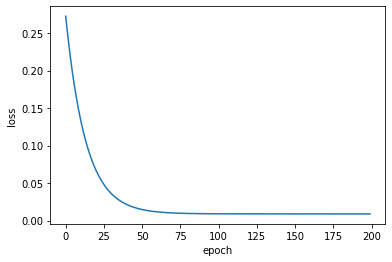

In [165]:
plt.plot(range(len(loss_trail)), loss_trail)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

예쁘게 쭉 떨어지는 loss 값을 보실수 있지요?   (Gradient 수식계산을 틀리지 않았나봐요 ㅠ.ㅠ) 위 코드에서 hyper-parameter 로 되어 있는 epoch 과 lr (learning rate) 을 한번 이리저리 바꿔보시면서 graph 에 어떤 변화가 생기는지를 한번 살펴보시기 바랍니다. epoch 을 1000 에 lr 을 0.001 로 바꿔보세요. 어떤 변화가 생기나요? 이게 왜 이렇게 되는지를 이해하시면 딥러닝 기본원리는 이해가 된겁니다 :)

보통 lr 을 0.0001 정도로 설정하고 여기서부터 튜닝하라고 나왔습니다만, 이건 그때그때 다릅니다. 나의 논문을 재현해서 남이 찾아놓은 값으로 실험을 할때야 다르겠습니다만, 나만의 데이터로 나의 모델을 돌릴때는 여기에서 엄청난 노가다가 발생합니다. 

## Vectorized Implementation

위에 구현해놓은 학습 알고리즘은 numpy 의 강력함을 하나도 이용하고 있지 않습니다. (어차피 개념만 이해하고 바로 pytorch 로 가버릴건데 이걸 굳이 설명해야 되나 싶기도 합니다만... Andrew Ng 교수님도 가르치셨으니 저도 여기에 적어두겠습니다. ) 위의 구현은 matrix 연산을 하나도 하고 있지 않습니다. for 문을 중첩해서 돌면서 numpy array 에서 값을 하나하나 꺼내어 계산을 하고 있는 방식입니다. 그럼 이걸 numpy 고유의 특징을 이용해서 한번에 계산해보도록 할까요?

눈여겨 보시면 for 문이 하나밖에 없을 겁니다. 그러나 기본적으로는 똑같은 구현입니다. ( 이해가 잘 안가시는 분은 이 섹션을 뛰어 넘으시면 되겠습니다. )

In [166]:
# 학습에 필요한 hyper-parameter 입니다. 이 값들의 의미는 수업시간에 설명을 드렸습니다.
epoch = 200
lr = 0.01

# 우리가 학습하려고 하는 w, b 는 random value 로 초기화(initialize)를 합니다.
w = 0.1
b = 0.1

# dataset 의 총숫자를 기록해둡니다.
num = len(x_train)

# loss 와 gradient 를 저장하기 위해서 필요한 변수들을 초기화합니다.
loss_trail = []

# 가지고 있는 data set 을 한번 모두 순회(traverse)한 것을 하나의 epoch 이라고 봅니다. 
for i in range(epoch):
    # y_hat, loss, 그리고 학습이 필요한 파라미터(w,b) 의 gradient 를 계산합니다.
    y_hat = w * x_train + b   # 간단히 표현되어 있지만 이게 우리 모델입니다 :)
    loss = 1 / 2 * ( y_train - ( w * x_train + b)) **2
    dldw = 2 * w * x_train ** 2 - 2 * x_train * y_train + 2 * x_train * b
    dldb = 2 * b + 2 * w * x_train - 2 * y_train
    # 이 값들을 다 더해서 데이터셋의 숫자로 나눠줍니다.
    loss = np.sum(loss)/num
    dldw = np.sum(dldw)/num
    dldb = np.sum(dldb)/num
    # 나중에 loss 가 어떻게 움직였는지를 보기 위한 graph 를 보기 위해서 저장합니다.
    loss_trail.append(loss)
    # 계산된 Gradient 를 update 합니다. 
    w = w - lr * dldw
    b = b - lr * dldb
    if i % 10 == 0:  
        print("epoch: %d, loss: %f" % (i,loss))

epoch: 0, loss: 0.150835
epoch: 10, loss: 0.075108
epoch: 20, loss: 0.039758
epoch: 30, loss: 0.023255
epoch: 40, loss: 0.015550
epoch: 50, loss: 0.011953
epoch: 60, loss: 0.010273
epoch: 70, loss: 0.009488
epoch: 80, loss: 0.009121
epoch: 90, loss: 0.008949
epoch: 100, loss: 0.008868
epoch: 110, loss: 0.008830
epoch: 120, loss: 0.008811
epoch: 130, loss: 0.008802
epoch: 140, loss: 0.008797
epoch: 150, loss: 0.008794
epoch: 160, loss: 0.008792
epoch: 170, loss: 0.008790
epoch: 180, loss: 0.008789
epoch: 190, loss: 0.008787


inner for-loop 이 없는데도 어째 비슷하게 계산이 되는것 같죠? Vectorized implementation 의 강력함은 다음번에 logistic regression 을 구현하면서 matrix 의 dimension 을 꼼꼼히 따져보면서 따라가 보도록 하겠습니다. 일단 지금 단계에서는 matrix 의 dimension 이 다 맞고, numpy 가 알아서 scalar 값을 broadcast 해주었기 때문이라고 해두고 넘어가죠.. 

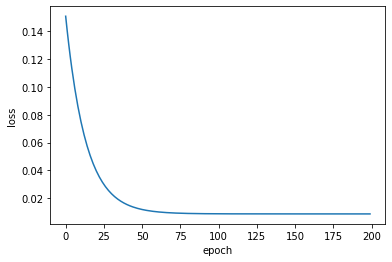

In [167]:
plt.plot(range(len(loss_trail)), loss_trail)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 학습이 끝난 모델의 활용 

이번에는 '학습'의 개념에 집중하느라고, 학습과정에서 이루어지는 검증과정(validation), 그리고 test 에 대해서 모두 생략하였습니다. 이 부분은 다음번에 logistic regression 을 공부하면서 좀더 자세히 알아보도록 하겠습니다. 그럼, 학습이 제대로 되었는지 한번 검증을 해볼까요.

우리가 학습을 시킨 parameter 는 뭐였죠? w,b 였죠.. 이 값이 얼마나 적절하게 이 data 를 표현(represent)하고 있는지 한번 살펴볼까요. 먼저, w,b 값이 얼마인지 한번 봅시다.


In [168]:
print(w,b)

0.37308389909785206 0.37816427282617493


x_train 값을 앞에서 340 으로 나누어서 normalize 를 했었죠.. normalize 된 상태에서 graph 를 다시 한번 그려보도록 합시다. 위로 올라가서 코드를 cut&paste 해옵니다 :)


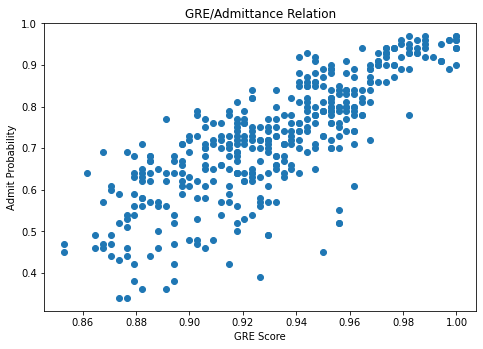

In [169]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter( x_train, y_train)
ax.set_xlabel('GRE Score')
ax.set_ylabel('Admit Probability')
ax.set_title('GRE/Admittance Relation')
plt.show()

모델의 예측값 계산을 위해서 학습이 끝난 모델에 집어넣을 x 값을 먼저 만들어 줍니다. 
그리고 모델의 예측값도 계산해줍니다. 

In [170]:
start_index = 290./340.
end_index = 340./340.

# 이게 무슨 의미인지 궁금하신 분들은 x 값을 출력해보세요.   np.arange(0,1,0.1) 해보시구요.
x = np.arange(start_index, end_index, 0.01)

# 두둥,,,, 모델에 값을 넣어봅시다. 
y = w * x + b


그리고 나서 다시 그래프를 그려봅시다.

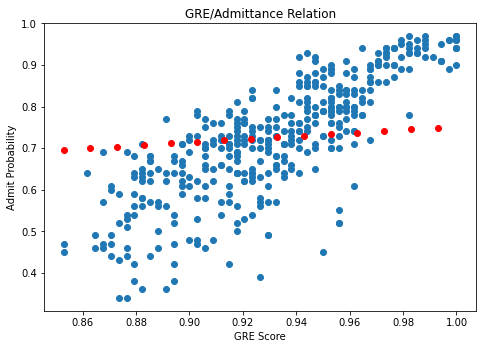

In [171]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter( x_train, y_train)
ax.scatter( x, y, color='r')  # 모델의 출력값은 빨간색으로 표시해봅니다.
ax.set_xlabel('GRE Score')
ax.set_ylabel('Admit Probability')
ax.set_title('GRE/Admittance Relation')
plt.show()

뭔가 좀 불만스러운 그래프가 나왔지요?  그러나 제가 보기엔 저게 최적값이 맞습니다 :) 모델의 표현력이 너무 간단하고, 그리고 GRE score 가 같은 학생끼리의 합격률의 분산(variance)가 굉장히 넓습니다.  

좀더 날카롭게 모여있는 Linear Regression dataset 을 찾아서 여러분께 숙제로 내어드리도록 하겠습니다. 그러나, 지금 데이터셋을 바꿀 엄두가 나질 않네요. 이 자료 만드는데도 이미 엄청난 시간을 써서요.  기본개념을 설명하는 linear regression, logistic regression 그리고 hidden layer 가 한두개 정도달린 neural network 정도에서만 기본을 가르쳐드리기 위해서 꼼꼼하게 자료를 만들겠습니다.  pytorch 쓰기 시작하면 그때부터는... 음 그냥 넣고 돌리면 대충 나옵니다 ㅠ.ㅠ  열공입니다!